# Topic modelling

In this notebook, we perform a topic modelling analysis of COVID-19 publications.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, pickle
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
df_meta = pd.read_csv("data/df_meta.csv",compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")

In [3]:
df_meta.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,timestamp,lang
0,0,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,NaN,NaN,NaN,0.1126/science.abb7331,NaN,NaN,NaN,2020-04-25 09:08:51.611715,en
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,32036640.0,NaN,pub.1124777091,2020-04-25 09:08:51.611715,en
2,2,Another Piece of the Puzzle: Human Metapneumov...,BACKGROUND: Each winter respiratory viruses ac...,2008.0,12.0,Archives of Internal Medicine,NaN,NaN,NaN,10.1001/archinte.168.22.2489,19064834.0,pmc2783624,NaN,2020-04-25 09:08:51.611715,en
3,3,Viral etiology of severe pneumonia among Kenya...,CONTEXT: Pneumonia is the leading cause of chi...,2010.0,5.0,JAMA,NaN,NaN,NaN,10.1001/jama.2010.675,20501927.0,pmc2968755,NaN,2020-04-25 09:08:51.611715,en
4,4,Critically Ill Patients With Influenza A(H1N1)...,NaN,2014.0,4.0,JAMA,NaN,NaN,NaN,10.1001/jama.2014.2116,24566924.0,pmc6689404,NaN,2020-04-25 09:08:51.611715,en


In [4]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'timestamp', 'lang'],
      dtype='object')

## Text analysis

In [5]:
# concatenate abstracts and titles

df_meta["title"] = df_meta["title"].fillna('')
df_meta["abstract"] = df_meta["abstract"].fillna('')
df_meta["title_abstract"] = df_meta.title +" "+df_meta.abstract

In [6]:
# note that ~16k articles have no abstract
df_meta[(df_meta["abstract"]=="")&(df_meta.lang=="en")].shape[0]

13852

In [7]:
# we focus on English

In [8]:
# coverage in Wikipedia of English or not

print("English:",df_joined_all[(df_joined_all["lang"]=='en') & (df_joined_all["in_wikipedia"]==True)].shape[0]/df_meta[df_meta["lang"]=='en'].shape[0])
print("Non English:",df_joined_all[(df_joined_all["lang"]!='en') & (df_joined_all["in_wikipedia"]==True)].shape[0]/df_meta[df_meta["lang"]!='en'].shape[0])

English: 0.032339535231263546
Non English: 0.003601833660772757


In [9]:
# coverage of non English sources is ~10 times lower

In [10]:
texts = df_meta[df_meta["lang"]=='en'].title_abstract.tolist()

In [11]:
df_meta.shape

(69969, 16)

In [12]:
len(texts)

66915

#### Topic modelling

In [13]:
from tqdm import tqdm
import gensim, sklearn
import scispacy
import spacy
import pyLDAvis.gensim

In [ ]:
!python -m spacy download en

In [34]:
#nlp = spacy.load('en')
nlp = spacy.load("en_core_sci_md")
#STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

In [35]:
%%time

# pre-processing: use lemmas and remove stopwords, add entities

processed_docs = list()
for doc in nlp.pipe(texts, n_process=6, batch_size=100):

    ents = doc.ents  # Named entities

    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and len(token) > 1]# token.is_alpha]

    # Add named entities, but only if they are a compound of more than one word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
                        
    processed_docs.append(doc)

CPU times: user 7min 48s, sys: 28.4 s, total: 8min 16s
Wall time: 10min 12s


In [36]:
import pickle

pickle.dump(processed_docs, open("data/processed_docs_scispacy_2.pk", "wb"))

In [14]:
import pickle

processed_docs = pickle.load(open("data/processed_docs_scispacy_2.pk", "rb"))

In [15]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more).
bigram = Phrases(docs, min_count=100)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [16]:
texts[0]

'‘A ticking time bomb’: Scientists worry about coronavirus spread in Africa CAPE TOWN, SOUTH AFRICA—Late on Sunday evening, South African President Cyril Ramaphosa, in a televised address to the nation, declared that COVID-19, the respiratory disease spreading globally, had become a “national disaster.” The declaration allows his government to access special funding and instigate harsh regulations to combat the viral outbreak. “Never before in the history of our democracy have we been confronted by such a severe situation,” Ramaphosa said before announcing a raft of measures to curb the virus’ spread, including school closures, travel restrictions, and bans on large gatherings. So far, the official numbers seemed to suggest that sub-Saharan Africa, home to more than 1 billion people, had been lucky. The interactive map of reported COVID-19 cases run by Johns Hopkins University shows big red blobs almost everywhere—except sub-Saharan Africa.'

In [17]:
" ".join(docs[0])

'tick time bomb scientist worry coronavirus spread Africa CAPE TOWN south AFRICA late Sunday evening south african President Cyril Ramaphosa televise address nation declare COVID-19 respiratory disease spreading globally national disaster declaration allow government access special funding instigate harsh regulation combat viral outbreak history democracy confront severe situation Ramaphosa say announce raft measure curb virus spread include school closure travel restriction ban large gathering far official number suggest sub-saharan Africa home billion people lucky interactive map report covid-19 case run Johns Hopkins University show big red blob sub-saharan Africa South African President Cyril Ramaphosa respiratory disease national disaster viral outbreak virus’ spread school closures official numbers sub-Saharan Africa Johns Hopkins University red blobs sub-Saharan Africa school_closure travel_restriction'

In [18]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
# Admittedly, values are arbitrary here.
max_freq = 0.5
min_wordcount = 10

In [19]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(texts)))

Number of unique tokens: 33394
Number of docs: 66915 (66915)


In [20]:
dictionary.token2id["covid-19"]

21

In [21]:
from collections import Counter

c = Counter()

for d in docs:
    c.update(d)

In [22]:
# most common words in the corpus, by frequency

c.most_common(min_wordcount)

[('virus', 76466),
 ('infection', 53337),
 ('cell', 45173),
 ('disease', 40026),
 ('patient', 39429),
 ('study', 39081),
 ('protein', 36651),
 ('viral', 33674),
 ('respiratory', 31996),
 ('result', 28996)]

## Correlated Topic Model

In [23]:
import tomotopy as tp

# CTM model with 15 topics, removal of words appearing in fewer than 0.5% of the documents, minimum word count but no trimming from above on frequent words
params = {'num_topics': 15, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 0, 'random_state': seed}
mdl = tp.CTModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'],rm_top=params['rm_top'])
#mdl = tp.HDPModel(min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'])
for doc in docs:
    mdl.add_doc(doc)

for i in range(0, 201, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

Iteration: 0	Log-likelihood: -7.445157708819118
Iteration: 10	Log-likelihood: -7.20869054772769
Iteration: 20	Log-likelihood: -6.978824507891025
Iteration: 30	Log-likelihood: -6.640410459097869
Iteration: 40	Log-likelihood: -6.283980653964459
Iteration: 50	Log-likelihood: -6.00302798164391
Iteration: 60	Log-likelihood: -5.804234795234119
Iteration: 70	Log-likelihood: -5.66341163360342
Iteration: 80	Log-likelihood: -5.562534189555964
Iteration: 90	Log-likelihood: -5.495960777106584
Iteration: 100	Log-likelihood: -5.452415627786642
Iteration: 110	Log-likelihood: -5.423672831196875
Iteration: 120	Log-likelihood: -5.403361823198562
Iteration: 130	Log-likelihood: -5.389507504564385
Iteration: 140	Log-likelihood: -5.380289337089308
Iteration: 150	Log-likelihood: -5.376475267085161
Iteration: 160	Log-likelihood: -5.374713840754044
Iteration: 170	Log-likelihood: -5.370592602063275
Iteration: 180	Log-likelihood: -5.36707760512652
Iteration: 190	Log-likelihood: -5.365672459848569
Iteration: 200	

In [56]:
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

Top 10 words of topic #0
[('disease', 0.10348976403474808), ('model', 0.04313496872782707), ('infectious', 0.033206406980752945), ('use', 0.025317855179309845), ('review', 0.024231920018792152), ('population', 0.022429782897233963), ('approach', 0.017951587215065956), ('research', 0.017910217866301537), ('individual', 0.015311727300286293), ('current', 0.014861839823424816)]
Top 10 words of topic #1
[('epidemic', 0.028205495327711105), ('outbreak', 0.027622178196907043), ('datum', 0.027120253071188927), ('transmission', 0.02604043483734131), ('number', 0.025063715875148773), ('spread', 0.02100219391286373), ('measure', 0.02058437652885914), ('control', 0.019298363476991653), ('SARS', 0.018869690597057343), ('case', 0.018554970622062683)]
Top 10 words of topic #2
[('virus', 0.23328667879104614), ('viral', 0.09850602596998215), ('strain', 0.03739740699529648), ('human', 0.029861794784665108), ('animal', 0.02670110948383808), ('isolate', 0.02187465876340866), ('specie', 0.0186010915786027

In [37]:
topic_labels = {
    "Coronaviruses": [11,12,13],
    "Public health and epidemics": [0,1,8],
    "Transmission": [2],
    "Molecular biology": [3,6,7],
    "Respiratory diseases": [5],
    "Immunology": [4],
    "Clinical medicine": [9,10,14]
}

In [38]:
# printout for LaTeX

#for k in range(mdl.k):
#    print("\\item \\textbf{Topic \\#%d}"%k+": "+"``"+"'', ``".join([w[0] for w in mdl.get_topic_words(k, top_n=30) if len(w[0])>2])+"''.")

In [39]:
# topics over time

df_local = df_meta[(df_meta["lang"]=='en') & (pd.notnull(df_meta["title_abstract"]))]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
pids = df_local.pub_id.tolist()
titles = df_local.title.tolist()
topics_corr = np.zeros((len(docs),params['num_topics']))

for n,doc in enumerate(mdl.docs):
    for m,t in enumerate(doc.get_topic_dist()):
        topics_corr[n][m] = t

In [40]:
df_topics_corr = pd.DataFrame(topics_corr)

In [41]:
df_topics_corr["year"] = publication_years
df_topics_corr["doi"] = dois

In [42]:
from_which_year = 1980

grouped_corr = df_topics_corr.groupby('year')
df_grouped_corr = grouped_corr.aggregate(np.mean)
df_grouped_corr = df_grouped_corr[df_grouped_corr.index >= from_which_year]
#df_grouped

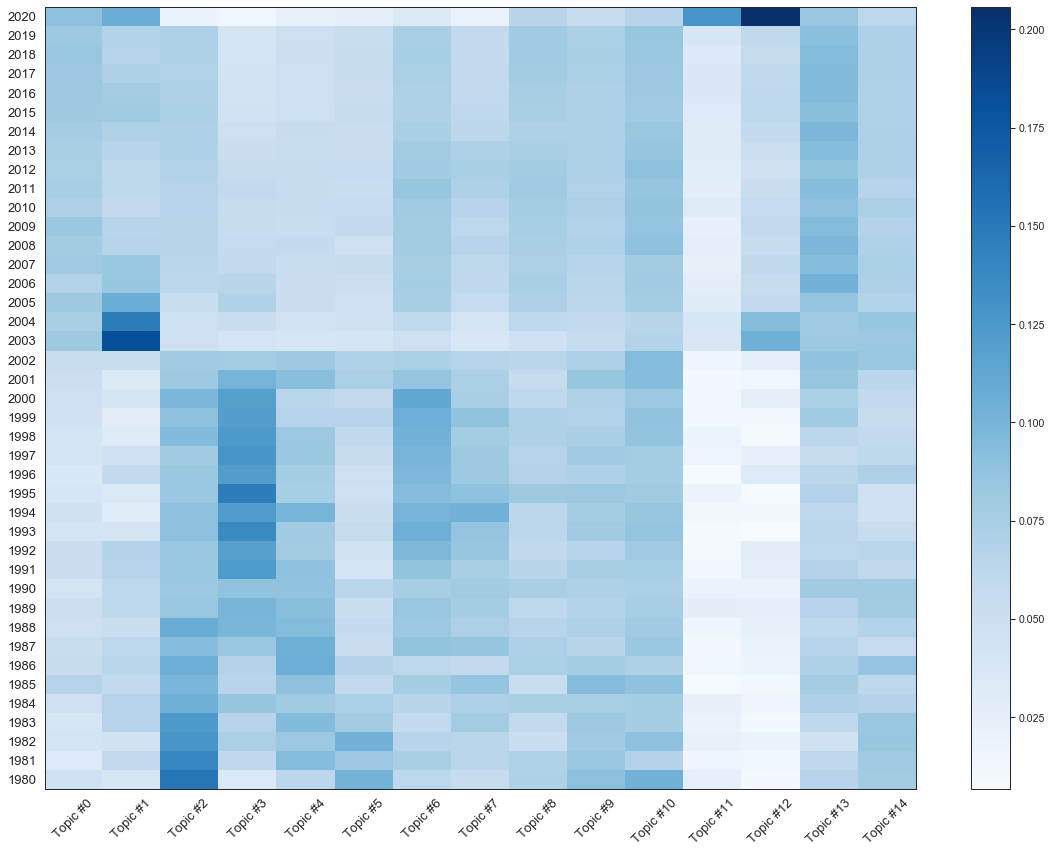

In [43]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped_corr.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped_corr.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped_corr.index.values])
plt.xticks(np.arange(df_grouped_corr.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/corr_topic_model_all_time_15_ctm.pdf")
plt.show()

In [44]:
# topic correlations

topics_correlations = np.zeros((mdl.k,mdl.k))

for k in range(mdl.k):
    for m,c in enumerate(mdl.get_correlations(k)):
        topics_correlations[k][m] = c

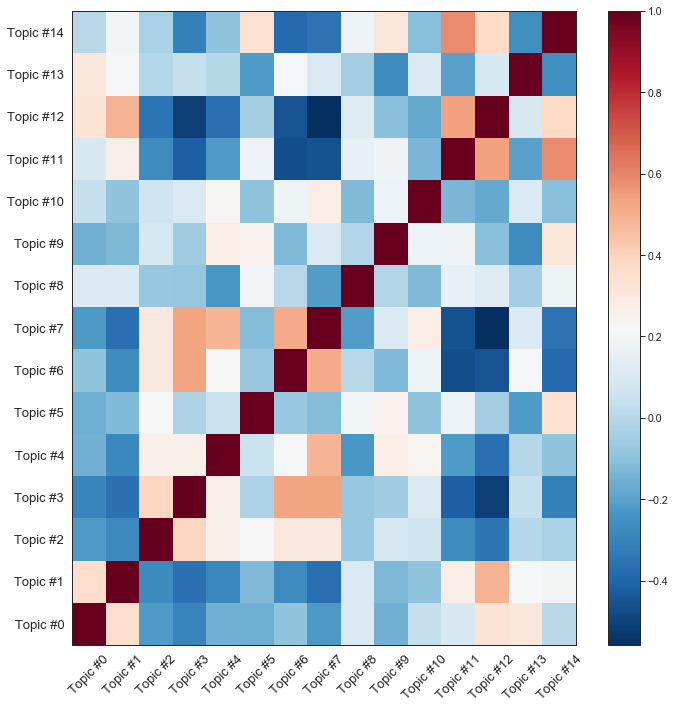

In [45]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)])
plt.xticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/corr_topic_model_correlations_15_ctm.pdf")

In [46]:
# calculate topic distances
from scipy.spatial.distance import cosine, euclidean, jensenshannon

topics_distances = np.zeros((mdl.k,mdl.k))
threshold = 1.0e-05 # apply a threshold on low prob words per topic

for k in range(mdl.k):
    for m in range(mdl.k)[k+1:]:
        d1 = np.array(mdl.get_topic_word_dist(k))
        d2 = np.array(mdl.get_topic_word_dist(m))
        ab_t = d1 < threshold
        d1[ab_t] = 0
        ab_t = d2 < threshold
        d2[ab_t] = 0
        d = jensenshannon(d1,d2)
        topics_distances[k][m] = d
        topics_distances[m][k] = d

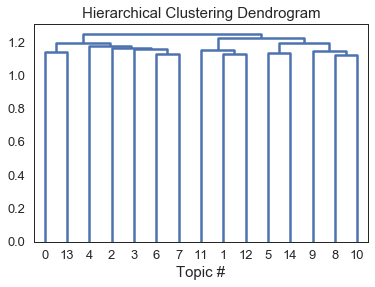

In [47]:
# From: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model_hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model_hc = model_hc.fit(topics_distances)
plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
# plot the top three levels of the dendrogram
plot_dendrogram(model_hc, truncate_mode='level', p=10)
plt.xlabel("Topic #", fontsize=15)
plt.tick_params(labelsize=13)
plt.savefig("figures/nb2_dendrogram_ctm.pdf")

#### Macrotopic analysis

In [48]:
# get number of papers per macro topic over time

is_selected_topic = {t:[0 for _ in range(len(docs))] for t in topic_labels.keys()}
topic_to_label = dict()
for k,v in topic_labels.items():
    for vv in v:
        topic_to_label[vv] = k
        
for n,doc in enumerate(mdl.docs):
    for m,t in enumerate(doc.get_topic_dist()):
        is_selected_topic[topic_to_label[m]][n] += t

In [49]:
# plot trends

df_topic_intensity = pd.DataFrame.from_dict(is_selected_topic)
df_topic_intensity["year"] = publication_years
df_topic_intensity["doi"] = dois
df_topic_intensity["pub_id"] = pids
df_topic_intensity["title"] = titles

In [50]:
from_which_year = 2000

grouped_ti = df_topic_intensity.groupby('year')
df_grouped_ti_m = grouped_ti.aggregate(np.mean)
df_grouped_ti_s = grouped_ti.aggregate(np.sum)
df_grouped_ti_m = df_grouped_ti_m[df_grouped_ti_m.index >= from_which_year]
df_grouped_ti_s = df_grouped_ti_s[df_grouped_ti_s.index >= from_which_year]

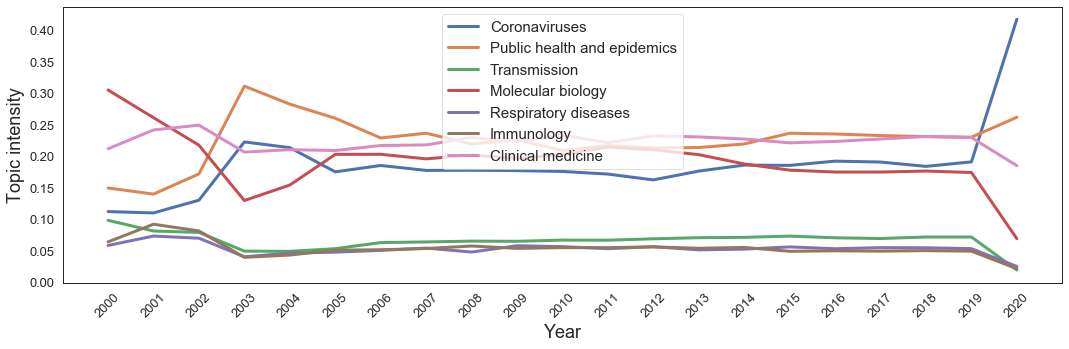

In [51]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti_m[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti_m.shape[0]), [int(x) for x in df_grouped_ti_m.index.values], rotation=45)
plt.legend(loc="upper center",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_mean_ctm.pdf")

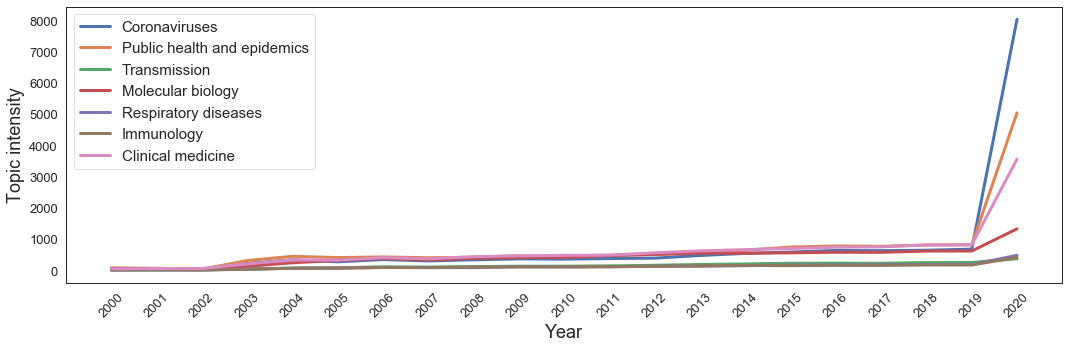

In [52]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti_s[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti_s.shape[0]), [int(x) for x in df_grouped_ti_s.index.values], rotation=45)
plt.legend(loc="upper left",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_sum_ctm.pdf")

In [53]:
# does it work?

df_topic_intensity.sort_values("Coronaviruses", ascending=False).head(10)

,Coronaviruses,Public health and epidemics,Transmission,Molecular biology,Respiratory diseases,Immunology,Clinical medicine,year,doi,pub_id,title
63222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,https://doi.org/10.1016/s2665-9913(20)30089-8,66183,Excitement around hydroxychloroquine for treat...
19088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,10.1016/j.jpainsymman.2020.03.030,20188,Conservative management of Covid-19 patients –...
62513,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,https://doi.org/10.1016/j.jpainsymman.2020.03.025,65408,Creating a Palliative Care Inpatient Response ...
55548,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,10.31646/gbio.50,58142,Wuhan novel coronavirus 2019nCoV
52123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,10.17226/25765,54564,Rapid Expert Consultation on Crisis Standards ...
33501,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,10.1093/eurheartj/ehaa266,35660,Experiences and lesson strategies for cardiolo...
18177,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,10.1016/j.jgo.2020.03.016,19262,Natural disaster and rationing of care
18392,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,10.1016/j.jhin.2020.04.008,19479,Preventing the Transmission of COVID-19 Amongs...
45482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,10.1177/1535370220920540,47802,"Novel 2019 coronavirus: Genome structure, clin..."
10847,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0,10.1016/b978-072169323-1.50094-5,11483,CHAPTER 91 Lambing Management and Neonatal Care


In [54]:
# save data frame

df_topic_intensity.drop(columns=["title","doi","year"], inplace=True)
df_topic_intensity.rename(columns={"Coronaviruses": "tm_coronaviruses",
    "Public health and epidemics": "tm_phe",
    "Transmission": "tm_transmission",
    "Molecular biology": "tm_molecular_biology",
    "Respiratory diseases": "tm_respiratory_diseases",
    "Immunology": "tm_immunology",
    "Clinical medicine": "tm_clinical_medicine"}, inplace=True)
df_topic_intensity.to_csv("data/df_topic_intensity_ctm.csv", compression="gzip", index=False)

## LDA

In [60]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 10, 'random_state': seed}
model = LdaModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 5min 41s, sys: 5.37 s, total: 5min 46s
Wall time: 5min 46s


In [61]:
model.show_topics(num_words=20, num_topics=params['num_topics'])

[(0,
  '0.040*"protein" + 0.016*"domain" + 0.016*"membrane" + 0.012*"structure" + 0.012*"binding" + 0.011*"receptor" + 0.011*"site" + 0.009*"fusion" + 0.009*"bind" + 0.009*"protease" + 0.008*"activity" + 0.008*"interaction" + 0.008*"acid" + 0.008*"glycoprotein" + 0.007*"complex" + 0.007*"ace2" + 0.007*"residue" + 0.006*"form" + 0.006*"entry" + 0.006*"cleavage"'),
 (1,
  '0.028*"sequence" + 0.027*"virus" + 0.021*"strain" + 0.019*"gene" + 0.016*"calf" + 0.014*"analysis" + 0.013*"isolate" + 0.013*"genome" + 0.010*"specie" + 0.010*"bat" + 0.008*"human" + 0.008*"genetic" + 0.008*"region" + 0.008*"identify" + 0.007*"ibv" + 0.006*"mutation" + 0.006*"host" + 0.006*"study" + 0.006*"variant" + 0.006*"different"'),
 (2,
  '0.021*"respiratory" + 0.017*"infection" + 0.013*"study" + 0.012*"year" + 0.011*"case" + 0.011*"child" + 0.010*"95" + 0.010*"age" + 0.009*"mers-cov" + 0.008*"risk" + 0.007*"associate" + 0.007*"high" + 0.007*"ci" + 0.007*"associated with" + 0.006*"patient" + 0.006*"Middle" + 0.00

In [55]:
# printout for LaTeX
#for t in model.show_topics(num_words=20, num_topics=params['num_topics'], formatted=False):
#    print("\\item \\textbf{Topic \\#%d}"%t[0]+": "+"``"+"'', ``".join([w[0] for w in t[1] if len(w[0])>2])+"''.")

In [78]:
# plot topics (NOTE: the IDs here do not match those from the model)
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [62]:
# topics over time

df_local = df_meta[(df_meta["lang"]=='en') & (pd.notnull(df_meta["title_abstract"]))]
publication_years = df_local.publication_year.tolist()
dois = df_local.doi.tolist()
pids = df_local.pub_id.tolist()
titles = df_local.title.tolist()
topics = np.zeros((len(docs),params['num_topics']))

for n,doc_topics in enumerate(model.get_document_topics(corpus)):
    for t in doc_topics:
        topics[n][t[0]] = t[1]

In [63]:
topics[0,:]

array([0.        , 0.        , 0.12008882, 0.04325084, 0.04622653,
       0.        , 0.        , 0.        , 0.        , 0.44007927,
       0.        , 0.        , 0.34267396, 0.        , 0.        ])

In [64]:
model.get_document_topics(corpus[0])

[(2, 0.12023233),
 (3, 0.04327447),
 (4, 0.045814343),
 (9, 0.44004542),
 (12, 0.3429528)]

In [65]:
df_topics = pd.DataFrame(topics)

In [66]:
df_topics["year"] = publication_years
df_topics["doi"] = dois

In [67]:
from_which_year = 1980

grouped = df_topics.groupby('year')
df_grouped = grouped.aggregate(np.mean)
df_grouped = df_grouped[df_grouped.index >= from_which_year]

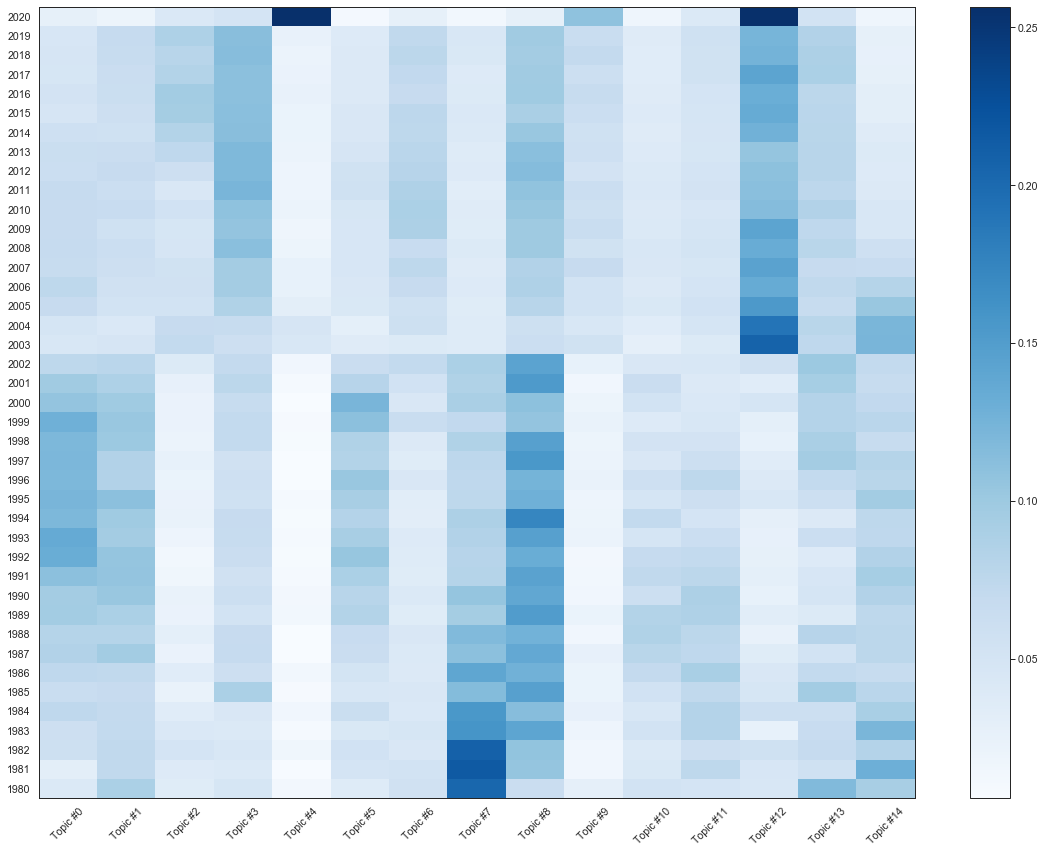

In [68]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped.index.values])
plt.xticks(np.arange(df_grouped.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(model.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_all_time_15.pdf")
plt.show()

In [69]:
# calculate topic distances
from scipy.spatial.distance import cosine, euclidean, jensenshannon

topics_distances = np.zeros((params['num_topics'],params['num_topics']))
topics_terms = model.state.get_lambda()

for k in range(params['num_topics']):
    for m in range(params['num_topics'])[k+1:]:
        d = jensenshannon(topics_terms[k,:],topics_terms[m,:])
        topics_distances[k][m] = d
        topics_distances[m][k] = d

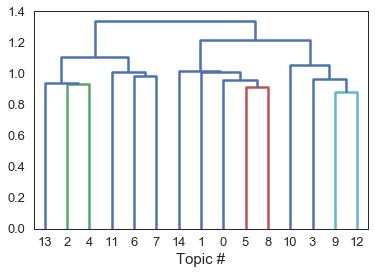

In [70]:
# From: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model_hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model_hc = model_hc.fit(topics_distances)
#plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
# plot the top three levels of the dendrogram
plot_dendrogram(model_hc, truncate_mode='level', p=10)
plt.xlabel("Topic #", fontsize=15)
plt.tick_params(labelsize=13)
plt.savefig("figures/nb2_dendrogram.pdf")

#### Macrotopic analysis

In [101]:
# define macro topics

topic_labels = {
    "Coronaviruses": [2,4],
    "Transmission": [1,7,14],
    "Public health and epidemics": [9,12],
    "Molecular biology": [0,5,8],
    "Respiratory diseases": [6],
    "Immunology": [3,10],
    "Clinical medicine": [11,13]
}

In [102]:
# get number of papers per macro topic over time

is_selected_topic = {t:[0 for _ in range(len(docs))] for t in topic_labels.keys()}
topic_to_label = dict()
for k,v in topic_labels.items():
    for vv in v:
        topic_to_label[vv] = k
for d in range(len(docs)):
    d_topics = model.get_document_topics(corpus[d])
    for x in d_topics:
        is_selected_topic[topic_to_label[x[0]]][d] += x[1]

In [103]:
# plot trends

df_topic_intensity = pd.DataFrame.from_dict(is_selected_topic)
df_topic_intensity["year"] = publication_years
df_topic_intensity["doi"] = dois
df_topic_intensity["pub_id"] = pids
df_topic_intensity["title"] = titles

In [104]:
from_which_year = 2000

grouped_ti = df_topic_intensity.groupby('year')
df_grouped_ti_m = grouped_ti.aggregate(np.mean)
df_grouped_ti_s = grouped_ti.aggregate(np.sum)
df_grouped_ti_m = df_grouped_ti_m[df_grouped_ti_m.index >= from_which_year]
df_grouped_ti_s = df_grouped_ti_s[df_grouped_ti_s.index >= from_which_year]

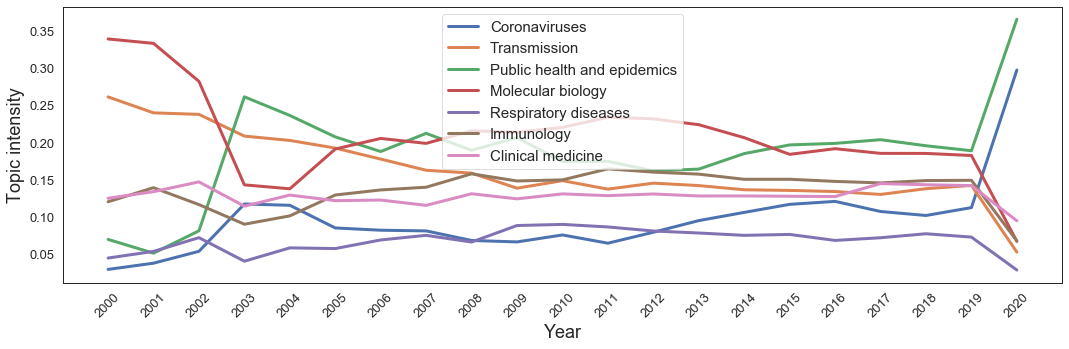

In [105]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti_m[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti_m.shape[0]), [int(x) for x in df_grouped_ti_m.index.values], rotation=45)
plt.legend(loc="upper center",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_mean.pdf")

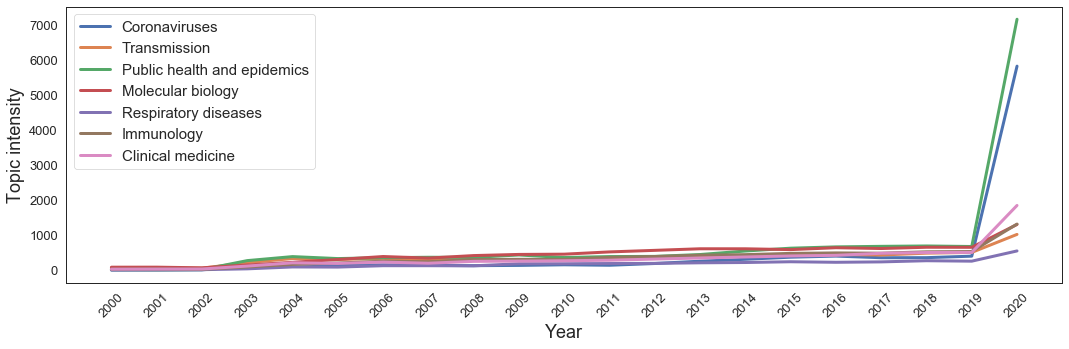

In [106]:
fig = plt.figure(figsize=(15, 5))
for k in topic_labels.keys():
    plt.plot(df_grouped_ti_s[k].values, label="%s"%k, linewidth=3)
plt.xticks(np.arange(df_grouped_ti_s.shape[0]), [int(x) for x in df_grouped_ti_s.index.values], rotation=45)
plt.legend(loc="upper left",fontsize=15)
plt.ylabel("Topic intensity",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
plt.savefig("figures/nb2_topic_model_trends_sum.pdf")

In [107]:
# does it work?

df_topic_intensity.sort_values("Coronaviruses", ascending=False).head()

,Coronaviruses,Transmission,Public health and epidemics,Molecular biology,Respiratory diseases,Immunology,Clinical medicine,year,doi,pub_id,title
33557,0.995769,0.000000,0.0,0.0,0.0,0.0,0.0,2020.0,10.1093/gerona/glaa089,35716,Clinical characteristics and outcomes of older...
15081,0.993112,0.000000,0.0,0.0,0.0,0.0,0.0,2020.0,10.1016/j.diagmicrobio.2019.114876,16053,The risk factors associated with MERS-CoV pati...
56692,0.986018,0.000000,0.0,0.0,0.0,0.0,0.0,2020.0,10.3346/jkms.2020.35.e132,59310,Analysis on 54 Mortality Cases of Coronavirus ...
1733,0.985553,0.000000,0.0,0.0,0.0,0.0,0.0,2020.0,10.1002/ppul.24762,1770,Novel coronavirus infection in children outsid...
35530,0.984581,0.011269,0.0,0.0,0.0,0.0,0.0,2020.0,10.1101/2020.02.06.20020974,37703,Clinical characteristics of 2019 novel coronav...


In [108]:
# save data frame

df_topic_intensity.drop(columns=["title","doi","year"], inplace=True)
df_topic_intensity.rename(columns={"Coronaviruses": "tm_coronaviruses",
    "Public health and epidemics": "tm_phe",
    "Transmission": "tm_transmission",
    "Molecular biology": "tm_molecular_biology",
    "Respiratory diseases": "tm_respiratory_diseases",
    "Immunology": "tm_immunology",
    "Clinical medicine": "tm_clinical_medicine"}, inplace=True)
df_topic_intensity.to_csv("data/df_topic_intensity.csv", compression="gzip", index=False)

### Support sections

##### Number of topics

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 3, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,# workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run
limit=50; start=5; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)])
plt.xticks(np.arange(mdl.k)+0.5, ["Topic #"+str(n) for n in range(mdl.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins